# CIFAR10 Classifier - T-Softmax loss and T-SNE Visualization

### Import packages

In [1]:
import numpy as np

import torch
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt

### Load and normalize CIFAR10

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 1

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


### NEURAL NETWORK WITH SOFTMAX FUNCTION

In [3]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

### Optimizer

In [4]:
import torch.optim as optim

optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

## T-softmax and cross entropy loss function

In [5]:
'''
Based on: 
https://zhang-yang.medium.com/understanding-cross-entropy-implementation-in-pytorch-softmax-log-softmax-nll-cross-entropy-416a2b200e34
'''

def T_softmax(x,T): 
    '''
    x - output from neural network,
    T - temperature parameter.
    '''
    x_T = x/T
    return x_T.exp() / x_T.exp().sum(-1)

def ce(input, target): 
    '''
    Negative logarithm of softmax values.
    '''
    log_prob = -1.0 * input.log()
    loss = log_prob.gather(1,target.unsqueeze(1))
    loss = loss.mean()
    return loss


### Training network

In [6]:
import torch.optim as optim
T = 1
epochs = 8
loss_vec_1 = []
for e in range(epochs):
  running_loss = 0
  for i, data in enumerate(trainloader, 0):
    # get the inputs; data is a list of [inputs, labels]
    inputs, labels = data

    # zero the parameter gradients
    optimizer.zero_grad()

    # forward + backward + optimize
    outputs = net(inputs)
    pred = T_softmax(outputs, T)
    loss = ce(pred, labels)
    loss.backward()
    optimizer.step()

    # print statistics
    running_loss += loss.item()
    if i % 4000 == 3999:    # print every 4000 mini-batches
        print(f'[{e + 1}, {i + 1:5d}] loss: {running_loss / 4000:.3f}')
        loss_vec_1.append(running_loss/4000)
        running_loss = 0.0

print('Finished Training')

/mnt/data/klaszewski/miniconda3/envs/nn_proj/lib/python3.9/site-packages/torch/autograd/__init__.py:154: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 101: invalid device ordinal (Triggered internally at  /opt/conda/conda-bld/pytorch_1640811803361/work/c10/cuda/CUDAFunctions.cpp:112.)
  Variable._execution_engine.run_backward(


[1,  4000] loss: 2.132
[1,  8000] loss: 1.865
[1, 12000] loss: 1.759
[1, 16000] loss: 1.671
[1, 20000] loss: 1.655
[1, 24000] loss: 1.631
[1, 28000] loss: 1.612
[1, 32000] loss: 1.593
[1, 36000] loss: 1.567
[1, 40000] loss: 1.560
[1, 44000] loss: 1.546
[1, 48000] loss: 1.547
[2,  4000] loss: 1.511
[2,  8000] loss: 1.518
[2, 12000] loss: 1.478
[2, 16000] loss: 1.500
[2, 20000] loss: 1.449
[2, 24000] loss: 1.476
[2, 28000] loss: 1.510
[2, 32000] loss: 1.487
[2, 36000] loss: 1.481
[2, 40000] loss: 1.480
[2, 44000] loss: 1.490
[2, 48000] loss: 1.499
[3,  4000] loss: 1.439
[3,  8000] loss: 1.437
[3, 12000] loss: 1.431
[3, 16000] loss: 1.450
[3, 20000] loss: 1.441
[3, 24000] loss: 1.445
[3, 28000] loss: 1.441
[3, 32000] loss: 1.421
[3, 36000] loss: 1.469
[3, 40000] loss: 1.455
[3, 44000] loss: 1.472
[3, 48000] loss: 1.424
[4,  4000] loss: 1.374
[4,  8000] loss: 1.369
[4, 12000] loss: 1.416
[4, 16000] loss: 1.388
[4, 20000] loss: 1.414
[4, 24000] loss: 1.440
[4, 28000] loss: 1.419
[4, 32000] 

In [7]:
import json
with open('loss_1.txt', 'w') as f:
    f.write(json.dumps(loss_vec_1))

### Load vectors of losses of different T-value

In [8]:
with open('loss_50.txt', 'r') as f:
    loss_50 = json.loads(f.read())

with open('loss_25.txt', 'r') as f:
    loss_25 = json.loads(f.read())
    
with open('loss_1.txt', 'r') as f:
    loss_1 = json.loads(f.read())
    
with open('loss_05.txt', 'r') as f:
    loss_05 = json.loads(f.read())
    
with open('loss_01.txt', 'r') as f:
    loss_01 = json.loads(f.read())
    
with open('loss_03.txt', 'r') as f:
    loss_03 = json.loads(f.read())

## Plot losses of different T values

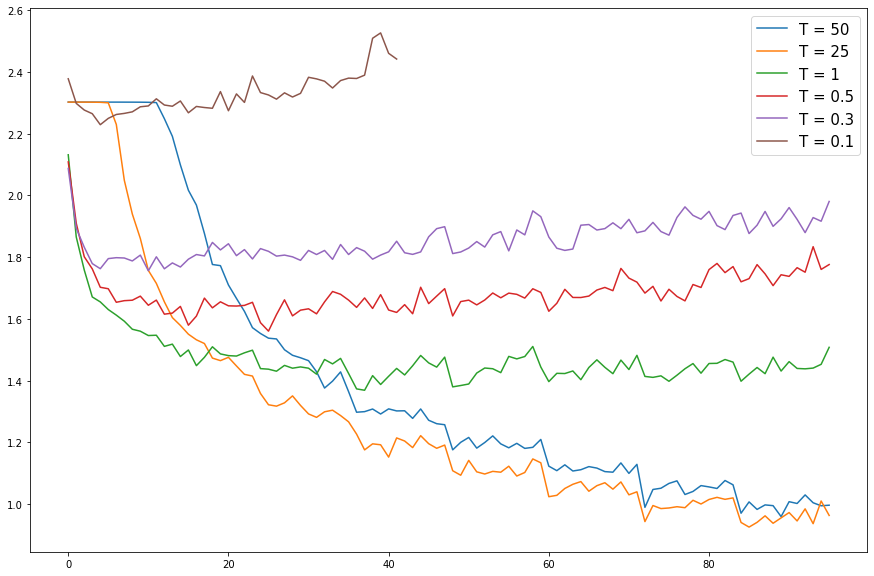

In [11]:
plt.figure(figsize=[15,10])
plt.plot(loss_50, label = "T = 50")
plt.plot(loss_25, label = "T = 25")
plt.plot(loss_1, label = "T = 1")
plt.plot(loss_05, label = "T = 0.5")
plt.plot(loss_03, label = "T = 0.3")
plt.plot(loss_01, label = "T = 0.1")
plt.legend(fontsize=15)
plt.show()

**For T-softmax with T = 0.1, get NaNs after few iterations.**

### Test network on dataset

In [12]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 48 %


### Predictions for each class

In [17]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')


Accuracy for class: plane is 60.2 %
Accuracy for class: car   is 76.4 %
Accuracy for class: bird  is 39.4 %
Accuracy for class: cat   is 30.6 %
Accuracy for class: deer  is 52.3 %
Accuracy for class: dog   is 31.4 %
Accuracy for class: frog  is 79.1 %
Accuracy for class: horse is 62.1 %
Accuracy for class: ship  is 80.1 %
Accuracy for class: truck is 59.2 %


In [13]:
vector = []
for i, data in enumerate(testloader):
    images, labels = data
    outputs1 = net(images)
    vector.append(outputs1[0].tolist())
    
vectors = np.array(vector)

In [14]:
label = []
for i, data in enumerate(testloader):
    images, labels = data
    label.append(labels[0].tolist())
    
labels_arr = np.array(label)

In [15]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, verbose=1, random_state=123)

embs = tsne.fit_transform(vectors)

/mnt/data/klaszewski/miniconda3/envs/nn_proj/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/mnt/data/klaszewski/miniconda3/envs/nn_proj/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.007s...
[t-SNE] Computed neighbors for 10000 samples in 0.456s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 80.108276
[t-SNE] KL divergence after 1000 iterations: 1.484850


In [16]:
import pandas as pd
df = pd.DataFrame()
df['x'] = embs[:, 0]
df['y'] = embs[:, 1]
df['label'] = labels_arr

In [17]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
c_labels = []
for i, data in enumerate(labels_arr):
    c_labels.append(classes[labels_arr[i]])

df['label'] = c_labels

# TSNE Visualization for T = 1, l-r = 0.001

Accuracy of the network on the 10000 test images: 48 %


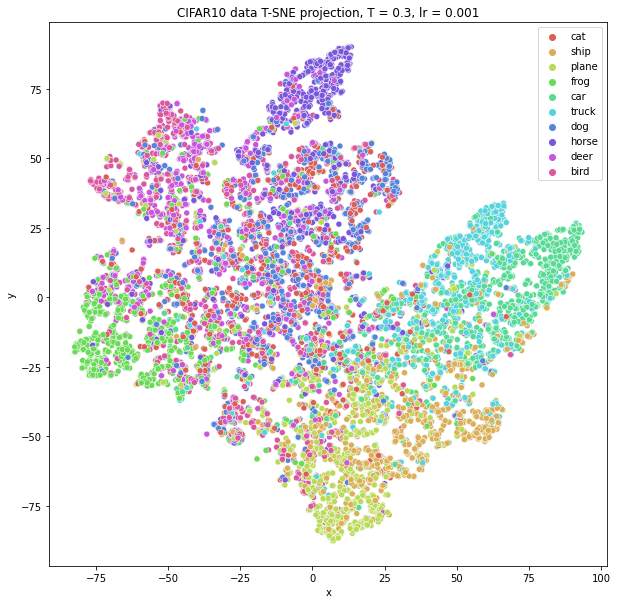

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

plt.figure(figsize=[10,10])
sns.scatterplot(x="x", y="y", hue=df.label.tolist(),
            palette=sns.color_palette("hls", 10),
            data=df).set(title="CIFAR10 data T-SNE projection, T = 0.3, lr = 0.001")
plt.show()

# TSNE Visualization for T = 0.3, l-r = 0.001

Accuracy of the network on the 10000 test images: 30 %


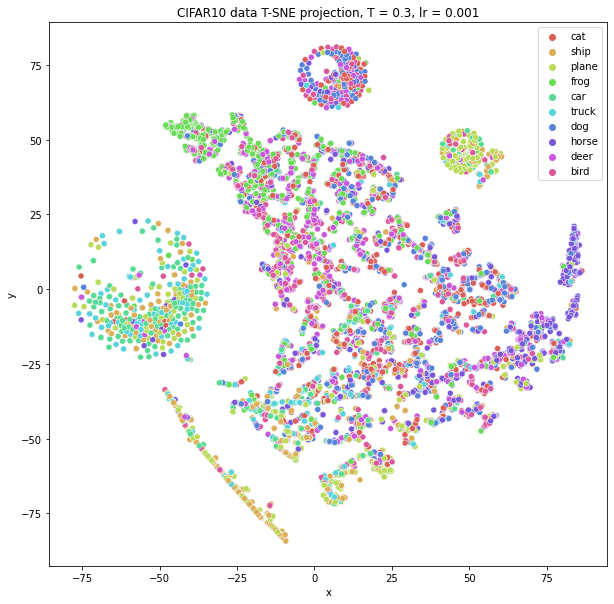

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

plt.figure(figsize=[10,10])
sns.scatterplot(x="x", y="y", hue=df.label.tolist(),
            palette=sns.color_palette("hls", 10),
            data=df).set(title="CIFAR10 data T-SNE projection, T = 0.3, lr = 0.001")
plt.show()

# TSNE Visualization for T = 0.5 and l-r = 0.001

Accuracy of the network on the 10000 test images: 30 %


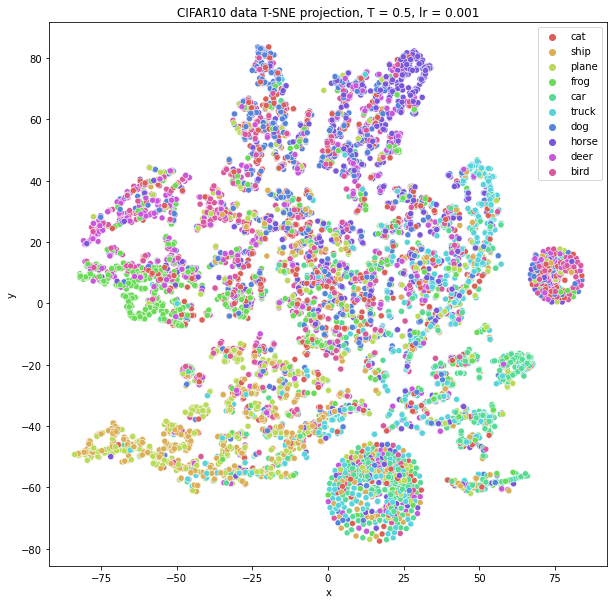

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

plt.figure(figsize=[10,10])
sns.scatterplot(x="x", y="y", hue=df.label.tolist(),
            palette=sns.color_palette("hls", 10),
            data=df).set(title="CIFAR10 data T-SNE projection, T = 0.5, lr = 0.001")
plt.show()

# TSNE Visualization for T = 25 and l-r = 0.001

Accuracy of the network on the 10000 test images: 62 %


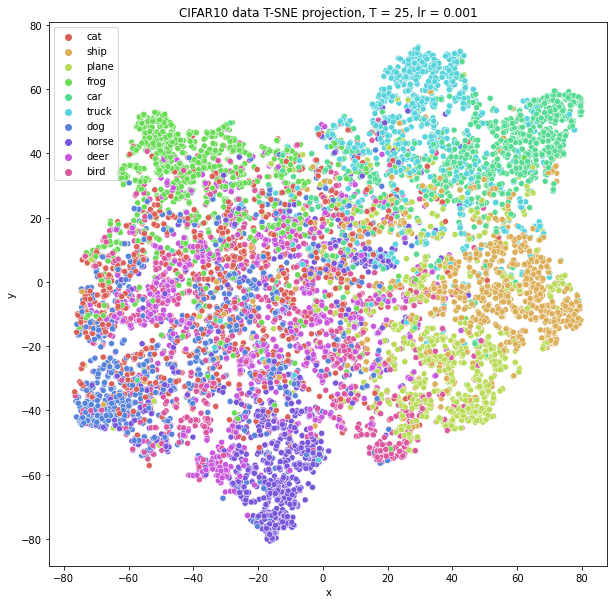

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

plt.figure(figsize=[10,10])
sns.scatterplot(x="x", y="y", hue=df.label.tolist(),
            palette=sns.color_palette("hls", 10),
            data=df).set(title="CIFAR10 data T-SNE projection, T = 25, lr = 0.001")
plt.show()

# TSNE Visualization for T = 50, l-r = 0.001

Accuracy of the network on the 10000 test images: 62 %


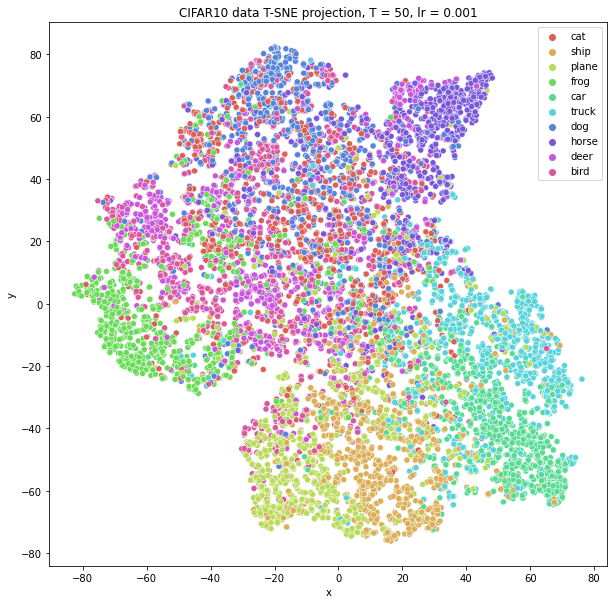

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

plt.figure(figsize=[10,10])
sns.scatterplot(x="x", y="y", hue=df.label.tolist(),
            palette=sns.color_palette("hls", 10),
            data=df).set(title="CIFAR10 data T-SNE projection, T = 50, lr = 0.001")
plt.show()

# Summary

One reason to use the temperature function is to change the output distribution computed by your neural net. It is added to the logits vector according to this equation :

- **𝑞𝑖 =exp(𝑧𝑖/𝑇)/ ∑𝑗exp(𝑧𝑗/𝑇)**

where 𝑇 is the temperature parameter.

T to be anything (the higher the T, the 'softer' the distribution will be - if it is 1, the output distribution will be the same as your normal softmax outputs). What I mean by 'softer' is that is that the model will basically be less confident about it's prediction. As T gets closer to 0, the 'harder' the distribution gets.


**For vanilla softmax - T = 1 - accuracy of model is 48%**

**For defined Neural Network, the best accuracy model gets with bigger T's:**
- T = 25, accuracy = 62%
- T = 50, accuracy = 62%.

**If T is between 0>T>1, accuracy of model is lower than from basic vanilla softmax**
- T = 0.3, accuracy = 30%
- T = 0.5, accuracy = 30%


**T-SNE**

For 0<T<1 points on visualization gives more separated embeddings, but groups of points are not in one color, which proves poor results of model. 
